# 시계열에 내포된 요인별 패턴을 데이터에서 분리해서 분석하는 방법

- 원 시계열 : 추세 순환주기, 계절성 및 불규칙 변동이 포함된 복합적인 형태
- 계절요인 : 중간 주기(월, 분기, 계절 등) 로 유사한 패턴이 반복되는 형태
- 추세 요인 : 시간 흐름에 따라 증가 또는 감소하는 형태
- 순환 요인 : 큰 주기(년, 경기 순환 등)로 변화하느느 형태
- 불규칙 요인 : 추세, 순환, 계절 요인으로는 설명되지 않는 변동

차분 : 데이터 정상성을 만족시키기 위해 적용 (1차, 2차 차분)

AR(자기회귀모델) : 이전 데이터(설명변수)가 현재 시점 데이터(목표변수)에 직접적으로 영향을 주는 회귀모델

MA(이동평균모델) : 일정 구간의 데이터 평균이 현재 시점의 데이터에 영향을 주는 추세분석 모델

ARMA(자기회귀 이동평균모델),  ARIMA(차분된 자기회귀 이동평균모델)

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
#!pip install pmdarima 처음 할떄 설치항목
from pmdarima import auto_arima

import warnings 
warnings.filterwarnings('ignore')

In [6]:
# parse_date : APPL_DATE 열이 날짜로 변환, 해석
df_raw = pd.read_csv('./실습화일/2. Big Data 분석/환율.csv',parse_dates=["APPL_DATE"])
df_raw.head()

,CURRENCY,APPL_DATE,STD_RATE,USD_CONV_DATE
0,CNY,2016-01-01,181.48,0.1541
1,JPY,2016-01-01,976.99,0.8294
2,USD,2016-01-01,1178.00,1.0000
3,CNY,2016-01-02,181.48,0.1541
4,JPY,2016-01-02,976.99,0.8294


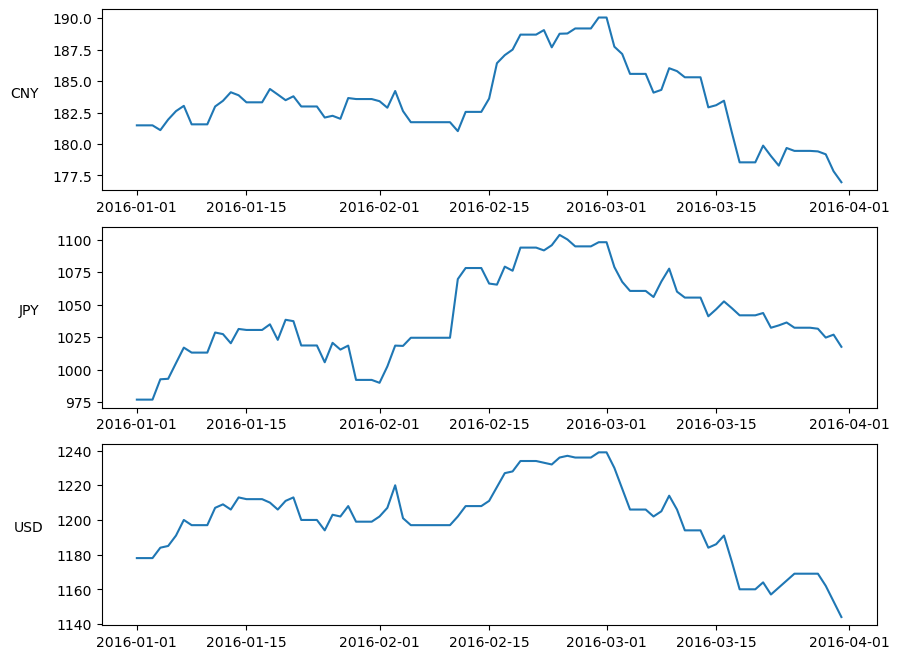

In [7]:
fig , (ax1,ax2,ax3) = plt.subplots(nrows = 3,ncols = 1, figsize=(10,8))

for (ax,idx,currency) in zip([ax1,ax2,ax3],[311,312,313],['CNY','JPY','USD']):
    ax.plot('APPL_DATE','STD_RATE',data=df_raw[df_raw['CURRENCY']==currency])
    ax.set_ylabel(currency,rotation=0,labelpad=20)

앞 구간과 뒷 구간의 평균이 다르고 변동이 달라 정상성이 만족되지 않음 >> 차분 필요 확인

In [8]:
#241
df_CNY = df_raw[df_raw['CURRENCY']=='CNY'].set_index('APPL_DATE')
df_CNY.drop(['CURRENCY','USD_CONV_DATE'],axis=1,inplace=True) 

df_JPY = df_raw[df_raw['CURRENCY']=="JPY"].set_index('APPL_DATE')
df_JPY.drop(['CURRENCY','USD_CONV_DATE'],axis=1,inplace=True)

df_USD = df_raw[df_raw['CURRENCY']=="USD"].set_index('APPL_DATE')
df_USD.drop(['CURRENCY','USD_CONV_DATE'],axis=1,inplace=True)
df_USD.head()

,STD_RATE
APPL_DATE,
2016-01-01,1178.0
2016-01-02,1178.0
2016-01-03,1178.0
2016-01-04,1184.0
2016-01-05,1185.0


In [9]:
train_size=0.9
len_idx=len(df_CNY.index)
mask=(np.arange(len_idx)/len_idx) < train_size
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False])

In [10]:
df_CNY_train = df_CNY[mask]
df_CNY_test = df_CNY[~mask]
print('shape of train data : {}'.format(df_CNY_train.shape))
print('shape of test data : {}'.format(df_CNY_test.shape))

shape of train data : (82, 1)
shape of test data : (9, 1)


In [11]:
df_CNY_train = df_CNY[df_CNY.index <= "2016-03-22"]
df_CNY_test = df_CNY[df_CNY.index > "2016-03-22"]
df_CNY_test.head() 

,STD_RATE
APPL_DATE,
2016-03-23,178.28
2016-03-24,179.68
2016-03-25,179.45
2016-03-26,179.45
2016-03-27,179.45


<Axes: xlabel='APPL_DATE'>

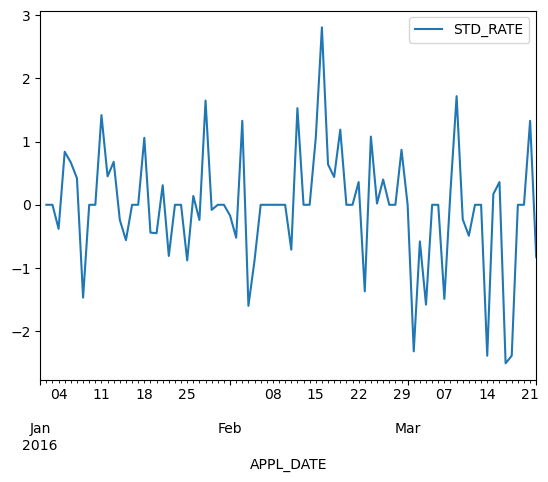

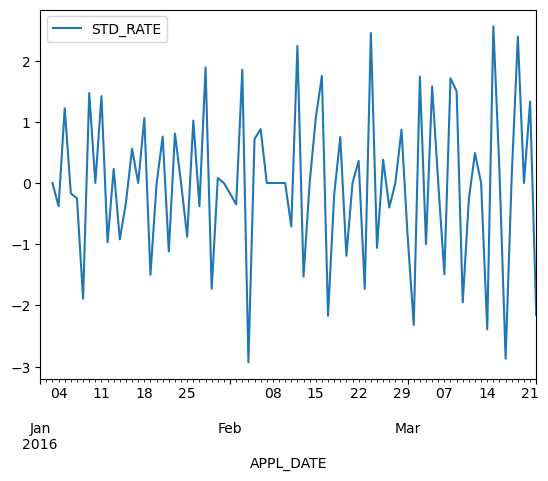

In [12]:
# 하루차이 수치변화     shift() : 해당 열을 1칸씩 옮겨 계산
df_CNY_diff1 = df_CNY_train - df_CNY_train.shift(1)
df_CNY_diff1.plot()

df_CNY_diff2 = df_CNY_train - 2* (df_CNY_train.shift(1)) + (df_CNY_train.shift(2))
df_CNY_diff2.plot()

1차 차분 : 원 데이터보다는 시간의 흐름에 영향을 덜 받지만 정상성이 만족스럽지 않음

2차 차분 : 시간에 따른 경향성을 가지지 않는 정상성을 만족

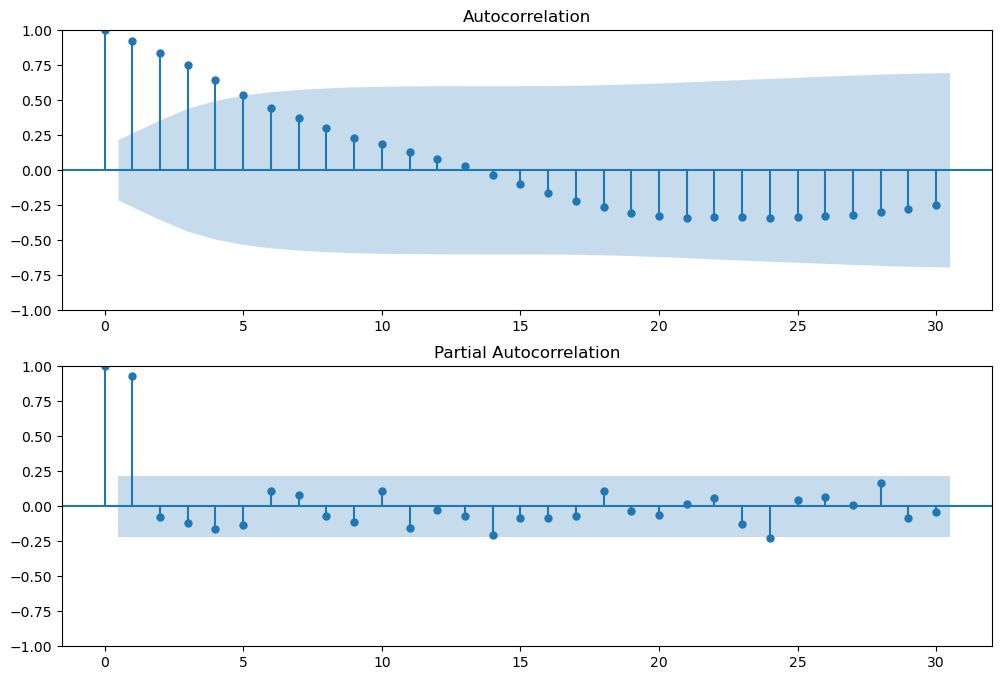

In [13]:
lag_size = 30
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = plot_acf(df_CNY_train['STD_RATE'],lags=lag_size,ax=ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(df_CNY_train['STD_RATE'],lags=lag_size,ax=ax2)

ACF는 지속적으로 감소하다가 p=13 시점에서 양에서 음으로 변하고, PACF는 p=1 시점에서 0.9보다 크고 이후 급격히 감소(절단명)

따라서 p=1, q=0 모델이 적합하다고 판단  > ARMA(1,0)

In [14]:
ts_model_cny = ARIMA(df_CNY_train,order=(1,2,0))
ts_result_cny = ts_model_cny.fit()
print(ts_result_cny.summary())

                               SARIMAX Results                                
Dep. Variable:               STD_RATE   No. Observations:                   82
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -123.513
Date:                Mon, 10 Jul 2023   AIC                            251.025
Time:                        22:44:09   BIC                            255.790
Sample:                    01-01-2016   HQIC                           252.936
                         - 03-22-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4389      0.106     -4.146      0.000      -0.646      -0.231
sigma2         1.2805      0.213      6.014      0.000       0.863       1.698
Ljung-Box (L1) (Q):                   2.62   Jarque-

ARIMA(1, 2, 0) 모델의 계수 유의성 확인

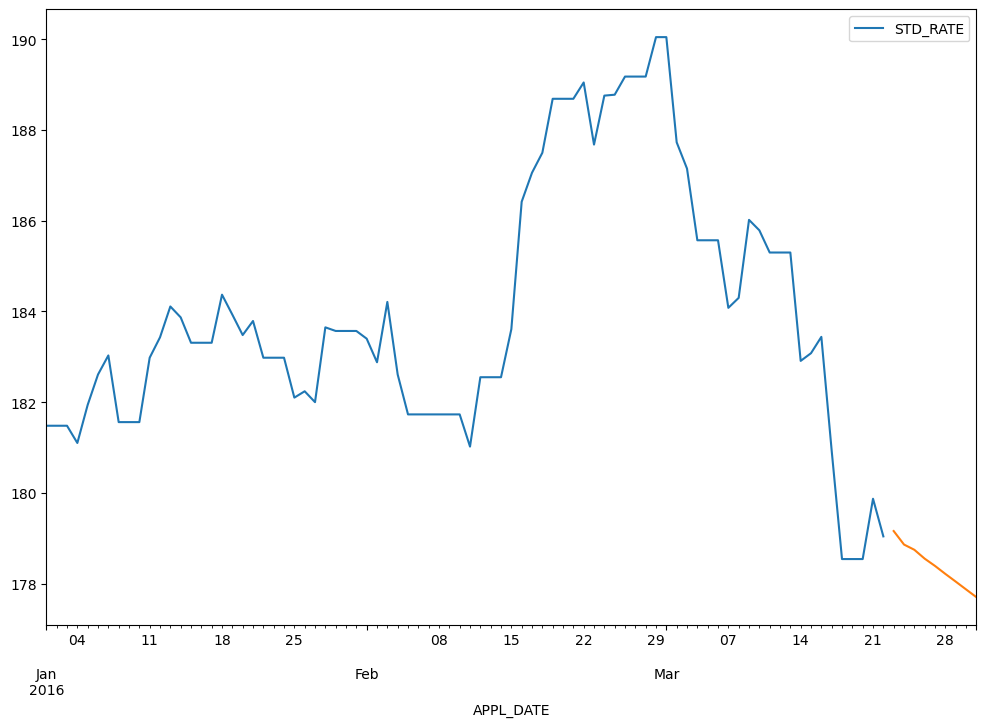

In [15]:
start_time=df_CNY_test.index.min()
end_time=df_CNY_test.index.max()
fig,ax = plt.subplots(figsize=(12,8))

ax=df_CNY_train.plot(ax=ax)
fig=ts_result_cny.predict(start=start_time, end=end_time, ax=ax,plot_insample=False).plot() # 겁나 오래 걸리는듯?

In [16]:
#247
start_time=pd.to_datetime('2016-01-03')
y_pred = ts_result_cny.predict(start=start_time, end=end_time, type ='levels')
df_merge = df_CNY
df_merge['예측값'] = y_pred
df_merge.head()

,STD_RATE,예측값
APPL_DATE,,
2016-01-01,181.48,NaN
2016-01-02,181.48,NaN
2016-01-03,181.48,181.480126
2016-01-04,181.10,181.480000
2016-01-05,181.94,180.886776


<Axes: xlabel='APPL_DATE'>

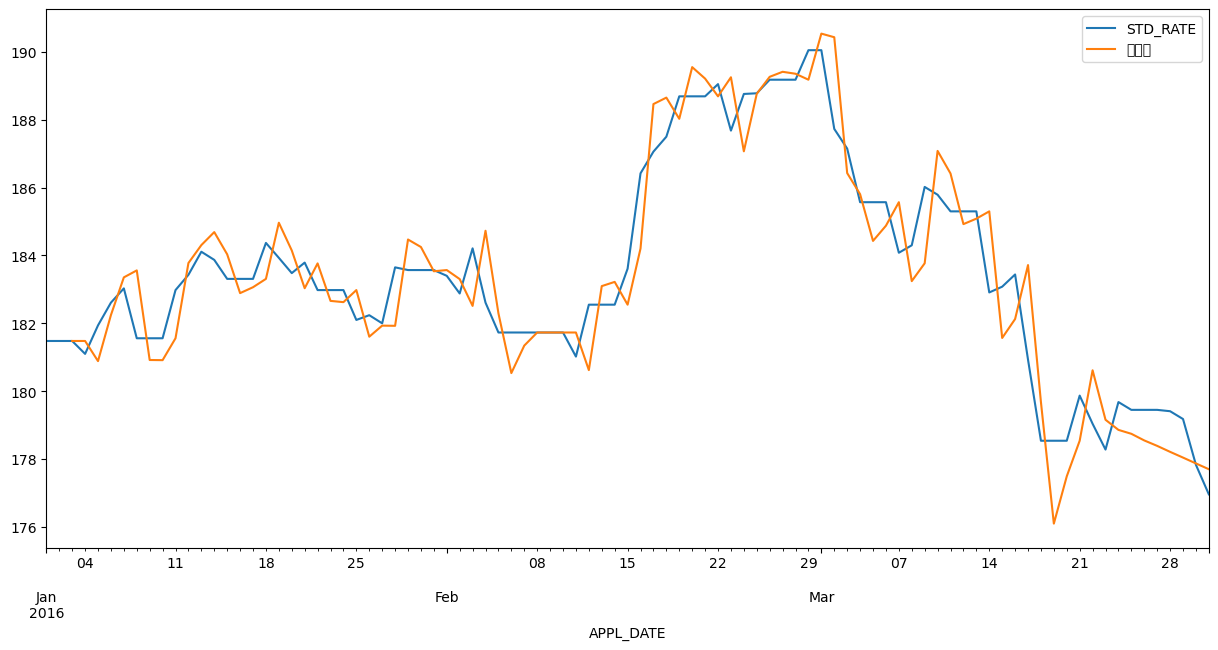

In [17]:
df_merge.plot(y=['STD_RATE','예측값'],figsize=(15,7))

In [18]:
ts_model=auto_arima(df_CNY_train, max_p=3, max_q=3,d=2,trace=True, error_action='ignore')

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=228.840, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=265.705, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=251.025, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=223.626, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=225.299, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=225.249, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=226.997, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.213 seconds


최적의 모수 ARIMA(0, 2, 1) 확인

In [19]:
ts_model_cny = ARIMA(df_CNY_train,order=(1,2,0))
ts_rsult_cny = ts_model_cny.fit()
print(ts_rsult_cny.summary())

                               SARIMAX Results                                
Dep. Variable:               STD_RATE   No. Observations:                   82
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -123.513
Date:                Mon, 10 Jul 2023   AIC                            251.025
Time:                        22:44:09   BIC                            255.790
Sample:                    01-01-2016   HQIC                           252.936
                         - 03-22-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4389      0.106     -4.146      0.000      -0.646      -0.231
sigma2         1.2805      0.213      6.014      0.000       0.863       1.698
Ljung-Box (L1) (Q):                   2.62   Jarque-

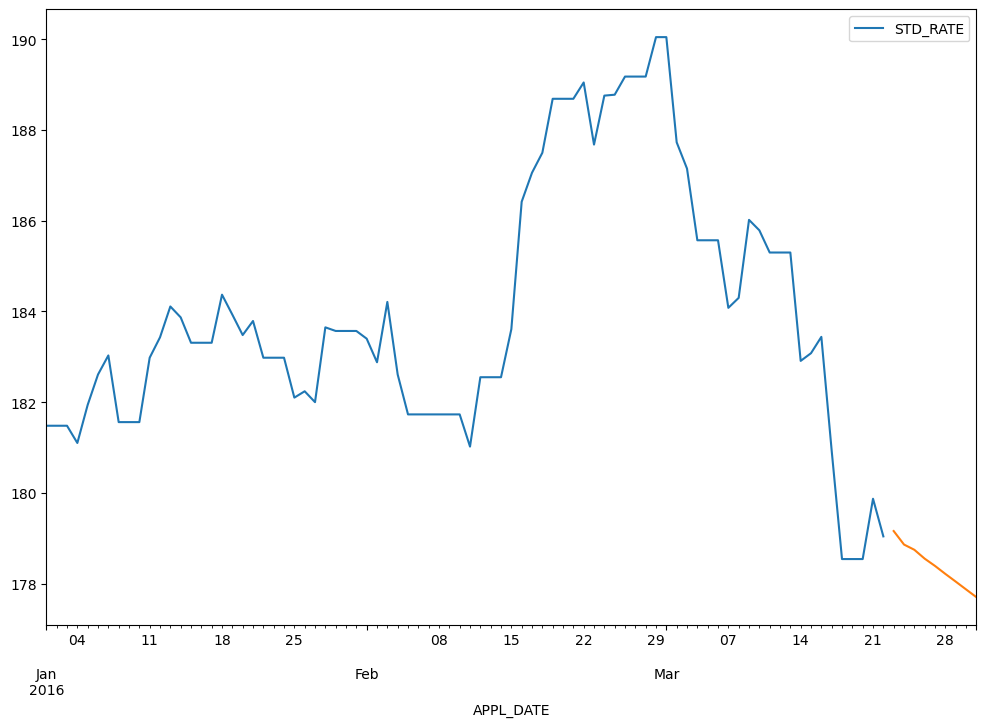

In [20]:
#250
start_time=df_CNY_test.index.min()
end_time=df_CNY_test.index.max()
fig,ax = plt.subplots(figsize=(12,8))

ax=df_CNY_train.plot(ax=ax)
fig=ts_result_cny.predict(start=start_time, end=end_time, ax=ax, plot_insample=False).plot() 

In [21]:
#251
start_time=pd.to_datetime('2016-01-03')
y_pred = ts_result_cny.predict(start=start_time, end=end_time, type ='levels')
df_merge = df_CNY
df_merge['예측값'] = y_pred
df_merge.head()

,STD_RATE,예측값
APPL_DATE,,
2016-01-01,181.48,NaN
2016-01-02,181.48,NaN
2016-01-03,181.48,181.480126
2016-01-04,181.10,181.480000
2016-01-05,181.94,180.886776


<Axes: xlabel='APPL_DATE'>

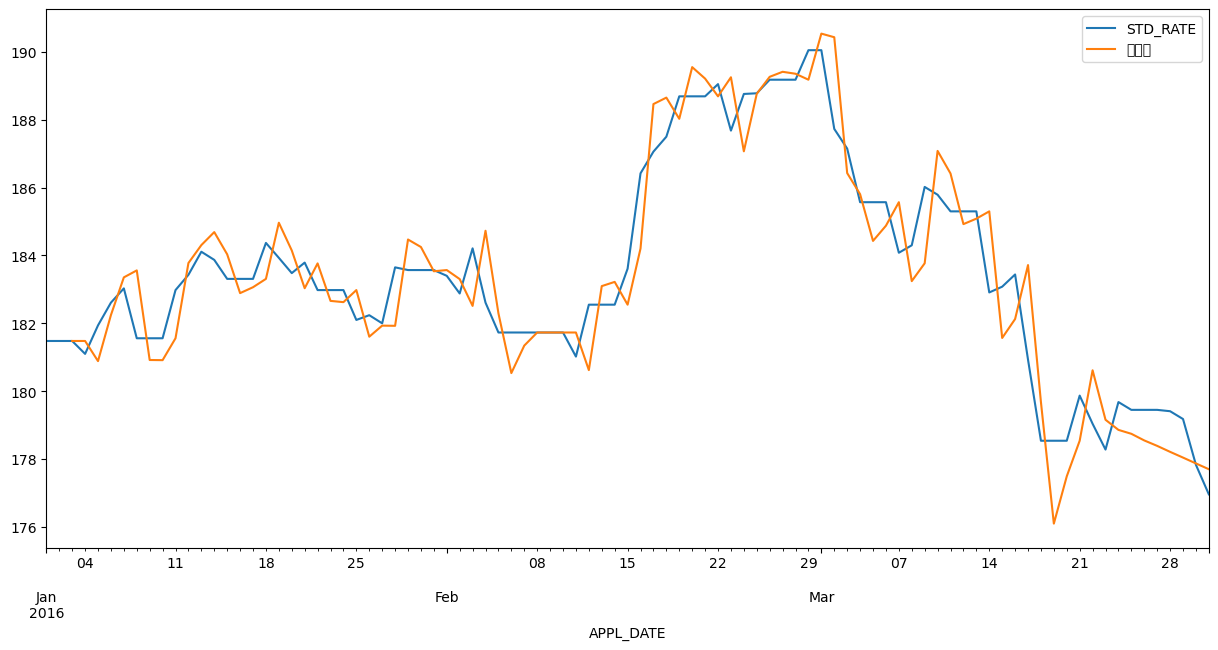

In [22]:
df_merge.plot(y=['STD_RATE','예측값'],figsize=(15,7))